In [1]:
import os
import cv2
import torch
import rasterio
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import Mask2FormerForUniversalSegmentation
import torch.nn as nn

from PIL import Image
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision.models.segmentation import deeplabv3_resnet50


c:\Users\saifk\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\saifk\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\_param_validation.py:14: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 2.4.2)
  from scipy.sparse import csr_matrix, issparse


In [2]:
image_dir = "Data\data-20260214T164319Z-1-001\data\images"
label_dir = "Data\data-20260214T164319Z-1-001\data\labels"

image_files = sorted(os.listdir(image_dir))
label_files = sorted(os.listdir(label_dir))

print("Number of images:", len(image_files))
print("Number of labels:", len(label_files))

Number of images: 306
Number of labels: 456


<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
C:\Users\saifk\AppData\Local\Temp\ipykernel_6440\2792036964.py:1: SyntaxWarning: invalid escape sequence '\d'
  image_dir = "Data\data-20260214T164319Z-1-001\data\images"
C:\Users\saifk\AppData\Local\Temp\ipykernel_6440\2792036964.py:2: SyntaxWarning: invalid escape sequence '\d'
  label_dir = "Data\data-20260214T164319Z-1-001\data\labels"


In [3]:
def compute_global_min_max(image_dir, selected_bands):
    images = sorted(os.listdir(image_dir))

    global_min = None
    global_max = None

    for img_name in images:
        img_path = os.path.join(image_dir, img_name)

        with rasterio.open(img_path) as src:
            image = src.read().astype(np.float32)

        image = image[selected_bands]

        if global_min is None:
            global_min = image.min(axis=(1,2))
            global_max = image.max(axis=(1,2))
        else:
            global_min = np.minimum(global_min, image.min(axis=(1,2)))
            global_max = np.maximum(global_max, image.max(axis=(1,2)))

    return global_min, global_max


selected_bands = [0, 1 , 2 ,3 , 4, 5, 6,7 ,8 ,9 ,10 , 11] 

global_min, global_max = compute_global_min_max(image_dir, selected_bands)

print("Global Min:", global_min)
print("Global Max:", global_max)

c:\Users\saifk\AppData\Local\Programs\Python\Python312\Lib\site-packages\rasterio\__init__.py:379: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, thread_safe=thread_safe, **kwargs)


Global Min: [-1.393e+03 -1.169e+03 -7.220e+02 -6.840e+02 -4.120e+02 -3.350e+02
 -2.580e+02  6.400e+01 -9.999e+03  8.000e+00  1.000e+01  0.000e+00]
Global Max: [ 6568.  9659. 11368. 12041. 15841. 15252. 14647.   255.  4245.  4287.
   100.   111.]


In [4]:
selected_bands = [0 ,1 ,4, 5 ,6 ,11]

class WaterDataset(Dataset):
    def __init__(self, image_dir, label_dir, selected_bands, global_min, global_max):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.images = sorted(os.listdir(image_dir))
        self.selected_bands = selected_bands
        self.global_min = global_min
        self.global_max = global_max

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.image_dir, img_name)
        mask_path = os.path.join(
            self.label_dir,
            os.path.splitext(img_name)[0] + ".png"
        )

        # Read image
        with rasterio.open(img_path) as src:
            image = src.read().astype(np.float32)

        image = image[self.selected_bands]  # (6,H,W)

        green = image[1]
        nir = image[3]
        ndwi = (green - nir) / (green + nir + 1e-8)

        ndwi = np.expand_dims(ndwi, axis=0)
        # image = np.concatenate([image, ndwi], axis=0)  # (7,H,W)

        for c in range(image.shape[0]):
            min_val = self.global_min[c]
            max_val = self.global_max[c]
            if max_val > min_val:
                image[c] = (image[c] - min_val) / (max_val - min_val)

        # Read mask
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = (mask > 0).astype(np.int64)

        return torch.tensor(image, dtype=torch.float32), torch.tensor(mask, dtype=torch.long)

In [5]:
dataset = WaterDataset(
    image_dir=image_dir,
    label_dir=label_dir,
    selected_bands=selected_bands,
    global_min=global_min,
    global_max=global_max
)

train_size = int(0.85 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(
    dataset,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=False)

### DeepLab

In [6]:
num_classes = 2 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = deeplabv3_resnet50(pretrained=True)

old_conv = model.backbone.conv1

new_conv = nn.Conv2d(
    6,
    old_conv.out_channels,
    kernel_size=old_conv.kernel_size,
    stride=old_conv.stride,
    padding=old_conv.padding,
    bias=False
)

# Copy pretrained weights for first 3 channels
new_conv.weight.data[:, :3] = old_conv.weight.data

# Initialize remaining 3 channels with mean of pretrained weights
new_conv.weight.data[:, 3:] = old_conv.weight.data.mean(dim=1, keepdim=True)

model.backbone.conv1 = new_conv

model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=1)

model = model.to(device)

c:\Users\saifk\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\saifk\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
def calculate_metrics(outputs, masks):
    # outputs: (B,2,H,W)
    # masks:   (B,H,W)

    preds = torch.argmax(outputs, dim=1)  # (B,H,W)

    preds = preds.view(-1)
    masks = masks.view(-1)

    TP = ((preds == 1) & (masks == 1)).sum().float()
    FP = ((preds == 1) & (masks == 0)).sum().float()
    FN = ((preds == 0) & (masks == 1)).sum().float()

    precision = TP / (TP + FP + 1e-8)
    recall = TP / (TP + FN + 1e-8)
    iou = TP / (TP + FP + FN + 1e-8)
    dice = (2 * TP) / (2 * TP + FP + FN + 1e-8)
    f1 = 2 * precision * recall / (precision + recall + 1e-8)

    return precision.item(), recall.item(), iou.item(), dice.item(), f1.item()

def dice_loss(outputs, masks, smooth=1e-6):
    # outputs: (B,2,H,W)
    # masks: (B,H,W)

    probs = F.softmax(outputs, dim=1)
    water_probs = probs[:, 1, :, :]  # class 1 = water

    water_probs = water_probs.contiguous().view(water_probs.size(0), -1)
    masks = masks.contiguous().view(masks.size(0), -1).float()

    intersection = (water_probs * masks).sum(dim=1)
    dice = (2 * intersection + smooth) / (
        water_probs.sum(dim=1) + masks.sum(dim=1) + smooth
    )

    return 1 - dice.mean()



In [9]:
criterion = nn.CrossEntropyLoss(weight=torch.tensor([0.3, 0.7]).to(device))

optimizer = optim.Adam(
    model.parameters(),
    lr=2e-5,
    weight_decay=2e-5
)

num_epochs = 50

train_losses = []
val_losses = []

for epoch in range(num_epochs):

    # ================= TRAIN =================
    model.train()
    train_loss = 0

    for imgs, masks in tqdm(train_loader):
        imgs = imgs.to(device)
        masks = masks.to(device)

        outputs = model(imgs)["out"]

        ce = criterion(outputs, masks)
        d_loss = dice_loss(outputs, masks)

        loss = ce + d_loss  

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # ================= VALIDATION =================
    model.eval()
    val_loss = 0
    val_precision = 0
    val_recall = 0
    val_iou = 0
    val_dice_metric = 0
    val_f1 = 0

    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs = imgs.to(device)
            masks = masks.to(device)

            outputs = model(imgs)["out"]

            ce = criterion(outputs, masks)
            d_loss = dice_loss(outputs, masks)

            loss = ce + d_loss
            val_loss += loss.item()

            # precision.item(), recall.item(), iou.item(), dice.item(), f1.item()
            precision, recall, iou, dice, f1 = calculate_metrics(outputs, masks)
            val_precision += precision
            val_recall += recall
            val_iou += iou
            val_dice_metric += dice
            val_f1 += f1

    val_loss /= len(val_loader)
    val_precision /= len(val_loader)
    val_recall /= len(val_loader)
    val_iou /= len(val_loader)
    val_dice_metric /= len(val_loader)
    val_f1 /= len(val_loader)

    val_losses.append(val_loss)

    print(f"\nEpoch [{epoch+1}/{num_epochs}]")
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val Loss:   {val_loss:.4f}")
    print(f"Val precision:   {val_precision:.4f}")
    print(f"Val recall:   {val_recall:.4f}")
    print(f"Val IoU:    {val_iou:.4f}")
    print(f"Val f1:   {val_f1:.4f}")

100%|██████████| 17/17 [00:05<00:00,  2.99it/s]



Epoch [1/50]
Train Loss: 1.1014
Val Loss:   1.1365
Val precision:   0.5030
Val recall:   0.8134
Val IoU:    0.4470
Val f1:   0.6173


100%|██████████| 17/17 [00:05<00:00,  3.21it/s]



Epoch [2/50]
Train Loss: 0.9915
Val Loss:   1.0169
Val precision:   0.6134
Val recall:   0.8046
Val IoU:    0.5334
Val f1:   0.6956


100%|██████████| 17/17 [00:05<00:00,  3.12it/s]



Epoch [3/50]
Train Loss: 0.9528
Val Loss:   0.9560
Val precision:   0.6302
Val recall:   0.8531
Val IoU:    0.5682
Val f1:   0.7244


100%|██████████| 17/17 [00:05<00:00,  3.17it/s]



Epoch [4/50]
Train Loss: 0.8719
Val Loss:   0.9189
Val precision:   0.6411
Val recall:   0.8567
Val IoU:    0.5774
Val f1:   0.7319


100%|██████████| 17/17 [00:05<00:00,  3.21it/s]



Epoch [5/50]
Train Loss: 0.8758
Val Loss:   0.9065
Val precision:   0.6377
Val recall:   0.8618
Val IoU:    0.5787
Val f1:   0.7326


100%|██████████| 17/17 [00:05<00:00,  3.23it/s]



Epoch [6/50]
Train Loss: 0.8122
Val Loss:   0.8850
Val precision:   0.6502
Val recall:   0.8962
Val IoU:    0.6049
Val f1:   0.7534


100%|██████████| 17/17 [00:05<00:00,  3.14it/s]



Epoch [7/50]
Train Loss: 0.7985
Val Loss:   0.8707
Val precision:   0.6611
Val recall:   0.8871
Val IoU:    0.6096
Val f1:   0.7571


100%|██████████| 17/17 [00:05<00:00,  3.03it/s]



Epoch [8/50]
Train Loss: 0.7763
Val Loss:   0.8504
Val precision:   0.7224
Val recall:   0.8243
Val IoU:    0.6262
Val f1:   0.7699


100%|██████████| 17/17 [00:05<00:00,  3.17it/s]



Epoch [9/50]
Train Loss: 0.7532
Val Loss:   0.8303
Val precision:   0.7043
Val recall:   0.8657
Val IoU:    0.6341
Val f1:   0.7760


100%|██████████| 17/17 [00:05<00:00,  3.10it/s]



Epoch [10/50]
Train Loss: 0.7268
Val Loss:   0.8105
Val precision:   0.7086
Val recall:   0.8741
Val IoU:    0.6418
Val f1:   0.7817


100%|██████████| 17/17 [00:05<00:00,  3.17it/s]



Epoch [11/50]
Train Loss: 0.7148
Val Loss:   0.8049
Val precision:   0.7076
Val recall:   0.8899
Val IoU:    0.6506
Val f1:   0.7881


100%|██████████| 17/17 [00:05<00:00,  3.23it/s]



Epoch [12/50]
Train Loss: 0.7292
Val Loss:   0.7989
Val precision:   0.7210
Val recall:   0.8702
Val IoU:    0.6508
Val f1:   0.7882


100%|██████████| 17/17 [00:05<00:00,  3.25it/s]



Epoch [13/50]
Train Loss: 0.7759
Val Loss:   0.7825
Val precision:   0.7045
Val recall:   0.8972
Val IoU:    0.6522
Val f1:   0.7892


100%|██████████| 17/17 [00:05<00:00,  3.20it/s]



Epoch [14/50]
Train Loss: 0.7034
Val Loss:   0.7920
Val precision:   0.7144
Val recall:   0.8966
Val IoU:    0.6597
Val f1:   0.7948


100%|██████████| 17/17 [00:05<00:00,  3.25it/s]



Epoch [15/50]
Train Loss: 0.6695
Val Loss:   0.7740
Val precision:   0.7197
Val recall:   0.8908
Val IoU:    0.6611
Val f1:   0.7958


100%|██████████| 17/17 [00:05<00:00,  3.21it/s]



Epoch [16/50]
Train Loss: 0.6709
Val Loss:   0.7741
Val precision:   0.7472
Val recall:   0.8635
Val IoU:    0.6685
Val f1:   0.8011


100%|██████████| 17/17 [00:05<00:00,  3.21it/s]



Epoch [17/50]
Train Loss: 0.6887
Val Loss:   0.7739
Val precision:   0.7114
Val recall:   0.9067
Val IoU:    0.6624
Val f1:   0.7968


100%|██████████| 17/17 [00:05<00:00,  3.22it/s]



Epoch [18/50]
Train Loss: 0.6677
Val Loss:   0.7591
Val precision:   0.7352
Val recall:   0.8934
Val IoU:    0.6758
Val f1:   0.8064


100%|██████████| 17/17 [00:05<00:00,  3.21it/s]



Epoch [19/50]
Train Loss: 0.6494
Val Loss:   0.7514
Val precision:   0.7461
Val recall:   0.8882
Val IoU:    0.6818
Val f1:   0.8107


100%|██████████| 17/17 [00:05<00:00,  3.20it/s]



Epoch [20/50]
Train Loss: 0.6641
Val Loss:   0.7479
Val precision:   0.7639
Val recall:   0.8696
Val IoU:    0.6856
Val f1:   0.8133


100%|██████████| 17/17 [00:05<00:00,  3.17it/s]



Epoch [21/50]
Train Loss: 0.6843
Val Loss:   0.7534
Val precision:   0.7382
Val recall:   0.8981
Val IoU:    0.6805
Val f1:   0.8097


100%|██████████| 17/17 [00:05<00:00,  3.22it/s]



Epoch [22/50]
Train Loss: 0.6814
Val Loss:   0.7600
Val precision:   0.7236
Val recall:   0.9105
Val IoU:    0.6755
Val f1:   0.8061


100%|██████████| 17/17 [00:05<00:00,  3.19it/s]



Epoch [23/50]
Train Loss: 0.6367
Val Loss:   0.7405
Val precision:   0.7788
Val recall:   0.8752
Val IoU:    0.7007
Val f1:   0.8239


100%|██████████| 17/17 [00:05<00:00,  3.14it/s]



Epoch [24/50]
Train Loss: 0.6322
Val Loss:   0.7305
Val precision:   0.7611
Val recall:   0.8901
Val IoU:    0.6953
Val f1:   0.8201


100%|██████████| 17/17 [00:05<00:00,  3.15it/s]



Epoch [25/50]
Train Loss: 0.6220
Val Loss:   0.7280
Val precision:   0.7537
Val recall:   0.8979
Val IoU:    0.6937
Val f1:   0.8190


100%|██████████| 17/17 [00:05<00:00,  3.14it/s]



Epoch [26/50]
Train Loss: 0.6278
Val Loss:   0.7254
Val precision:   0.7732
Val recall:   0.8807
Val IoU:    0.6990
Val f1:   0.8226


100%|██████████| 17/17 [00:05<00:00,  3.10it/s]



Epoch [27/50]
Train Loss: 0.6056
Val Loss:   0.7198
Val precision:   0.7807
Val recall:   0.8744
Val IoU:    0.7015
Val f1:   0.8244


100%|██████████| 17/17 [00:05<00:00,  3.13it/s]



Epoch [28/50]
Train Loss: 0.6478
Val Loss:   0.7372
Val precision:   0.7692
Val recall:   0.8702
Val IoU:    0.6897
Val f1:   0.8162


100%|██████████| 17/17 [00:05<00:00,  3.13it/s]



Epoch [29/50]
Train Loss: 0.6247
Val Loss:   0.7250
Val precision:   0.7852
Val recall:   0.8664
Val IoU:    0.6999
Val f1:   0.8234


100%|██████████| 17/17 [00:05<00:00,  3.14it/s]



Epoch [30/50]
Train Loss: 0.6165
Val Loss:   0.7194
Val precision:   0.7599
Val recall:   0.8938
Val IoU:    0.6955
Val f1:   0.8202


100%|██████████| 17/17 [00:05<00:00,  3.14it/s]



Epoch [31/50]
Train Loss: 0.6141
Val Loss:   0.7277
Val precision:   0.7187
Val recall:   0.9312
Val IoU:    0.6817
Val f1:   0.8106


100%|██████████| 17/17 [00:05<00:00,  3.19it/s]



Epoch [32/50]
Train Loss: 0.5936
Val Loss:   0.7016
Val precision:   0.7920
Val recall:   0.8784
Val IoU:    0.7134
Val f1:   0.8326


100%|██████████| 17/17 [00:05<00:00,  3.19it/s]



Epoch [33/50]
Train Loss: 0.5929
Val Loss:   0.7093
Val precision:   0.7856
Val recall:   0.8746
Val IoU:    0.7054
Val f1:   0.8272


100%|██████████| 17/17 [00:05<00:00,  3.09it/s]



Epoch [34/50]
Train Loss: 0.5861
Val Loss:   0.7174
Val precision:   0.7492
Val recall:   0.8984
Val IoU:    0.6891
Val f1:   0.8159


100%|██████████| 17/17 [00:05<00:00,  3.15it/s]



Epoch [35/50]
Train Loss: 0.6548
Val Loss:   0.6997
Val precision:   0.7455
Val recall:   0.9188
Val IoU:    0.6985
Val f1:   0.8225


100%|██████████| 17/17 [00:05<00:00,  3.17it/s]



Epoch [36/50]
Train Loss: 0.5757
Val Loss:   0.6996
Val precision:   0.7678
Val recall:   0.9027
Val IoU:    0.7081
Val f1:   0.8291


100%|██████████| 17/17 [00:05<00:00,  3.16it/s]



Epoch [37/50]
Train Loss: 0.5977
Val Loss:   0.6889
Val precision:   0.7695
Val recall:   0.9040
Val IoU:    0.7106
Val f1:   0.8308


100%|██████████| 17/17 [00:05<00:00,  3.05it/s]



Epoch [38/50]
Train Loss: 0.5631
Val Loss:   0.6899
Val precision:   0.7955
Val recall:   0.8846
Val IoU:    0.7203
Val f1:   0.8373


100%|██████████| 17/17 [00:05<00:00,  3.11it/s]



Epoch [39/50]
Train Loss: 0.5581
Val Loss:   0.6882
Val precision:   0.7892
Val recall:   0.8893
Val IoU:    0.7181
Val f1:   0.8358


100%|██████████| 17/17 [00:05<00:00,  3.08it/s]



Epoch [40/50]
Train Loss: 0.6071
Val Loss:   0.6942
Val precision:   0.7731
Val recall:   0.9071
Val IoU:    0.7160
Val f1:   0.8344


100%|██████████| 17/17 [00:05<00:00,  3.13it/s]



Epoch [41/50]
Train Loss: 0.5654
Val Loss:   0.6766
Val precision:   0.7890
Val recall:   0.9018
Val IoU:    0.7262
Val f1:   0.8413


100%|██████████| 17/17 [00:05<00:00,  3.15it/s]



Epoch [42/50]
Train Loss: 0.6325
Val Loss:   0.6837
Val precision:   0.7924
Val recall:   0.8929
Val IoU:    0.7234
Val f1:   0.8394


100%|██████████| 17/17 [00:05<00:00,  3.16it/s]



Epoch [43/50]
Train Loss: 0.5858
Val Loss:   0.7298
Val precision:   0.7316
Val recall:   0.9149
Val IoU:    0.6840
Val f1:   0.8120


100%|██████████| 17/17 [00:05<00:00,  3.15it/s]



Epoch [44/50]
Train Loss: 0.5746
Val Loss:   0.6962
Val precision:   0.7734
Val recall:   0.9034
Val IoU:    0.7142
Val f1:   0.8331


100%|██████████| 17/17 [00:05<00:00,  2.95it/s]



Epoch [45/50]
Train Loss: 0.5481
Val Loss:   0.6902
Val precision:   0.7834
Val recall:   0.8975
Val IoU:    0.7190
Val f1:   0.8363


100%|██████████| 17/17 [00:05<00:00,  3.11it/s]



Epoch [46/50]
Train Loss: 0.5376
Val Loss:   0.6795
Val precision:   0.8064
Val recall:   0.8837
Val IoU:    0.7288
Val f1:   0.8430


100%|██████████| 17/17 [00:05<00:00,  3.08it/s]



Epoch [47/50]
Train Loss: 0.6176
Val Loss:   0.6765
Val precision:   0.7935
Val recall:   0.8960
Val IoU:    0.7267
Val f1:   0.8415


100%|██████████| 17/17 [00:05<00:00,  3.08it/s]



Epoch [48/50]
Train Loss: 0.5535
Val Loss:   0.6873
Val precision:   0.7855
Val recall:   0.8950
Val IoU:    0.7192
Val f1:   0.8366


100%|██████████| 17/17 [00:05<00:00,  3.13it/s]



Epoch [49/50]
Train Loss: 0.5357
Val Loss:   0.6770
Val precision:   0.7889
Val recall:   0.8925
Val IoU:    0.7205
Val f1:   0.8374


100%|██████████| 17/17 [00:05<00:00,  3.09it/s]



Epoch [50/50]
Train Loss: 0.5299
Val Loss:   0.6823
Val precision:   0.8184
Val recall:   0.8631
Val IoU:    0.7245
Val f1:   0.8401


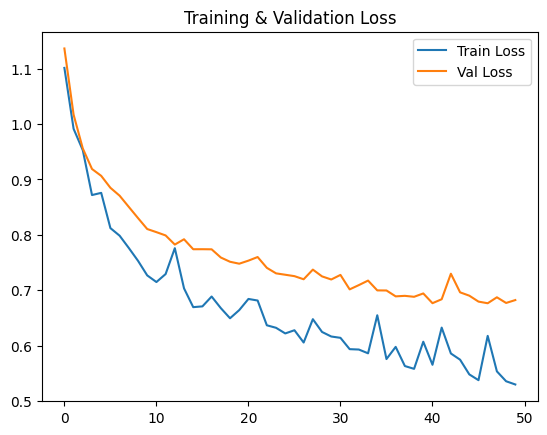

In [10]:
plt.figure()
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend()
plt.title("Training & Validation Loss")
plt.show()

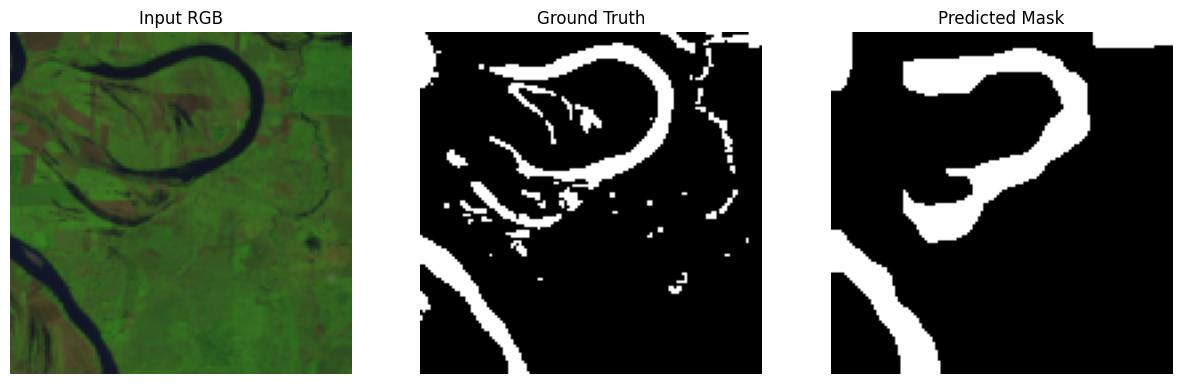

In [11]:
model.eval()

with torch.no_grad():
    images, masks = next(iter(val_loader))
    images = images.to(device)
    masks = masks.to(device)

    outputs = model(images)["out"]
    preds = torch.argmax(outputs, dim=1)

images = images.cpu()
masks = masks.cpu()
preds = preds.cpu()

img = images[0]
gt = masks[0]
pred = preds[0]

# Remove channel dim if exists
if gt.dim() == 3:
    gt = gt.squeeze(0)

if pred.dim() == 3:
    pred = pred.squeeze(0)

# Handle RGB
if img.shape[0] >= 3:
    rgb = torch.stack([img[3], img[2], img[1]], dim=0)
    rgb = rgb.permute(1, 2, 0)
else:
    rgb = img.permute(1, 2, 0)

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(rgb)
plt.title("Input RGB")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(gt, cmap="gray")
plt.title("Ground Truth")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(pred, cmap="gray")
plt.title("Predicted Mask")
plt.axis("off")

plt.show()

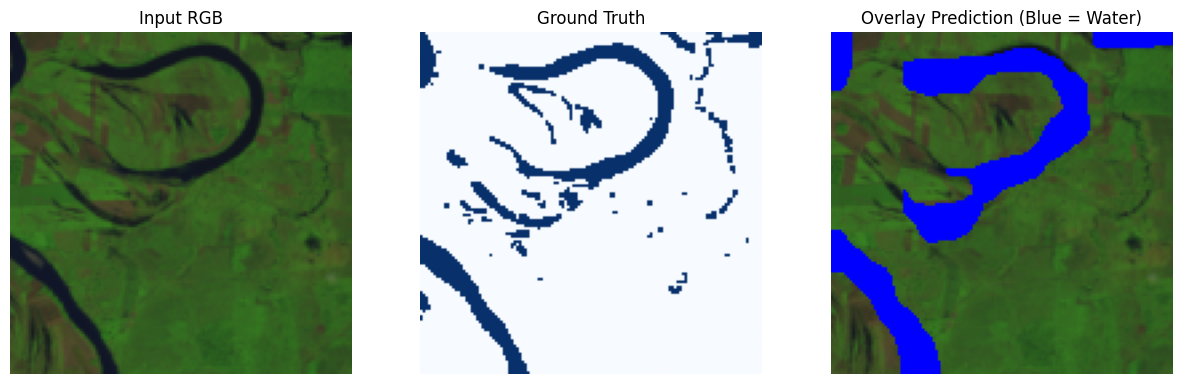

In [12]:
rgb_np = rgb.numpy()

overlay = rgb_np.copy()

overlay[pred.numpy() == 1] = [0, 0, 1]

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(rgb_np)
plt.title("Input RGB")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(gt, cmap="Blues")
plt.title("Ground Truth")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(overlay)
plt.title("Overlay Prediction (Blue = Water)")
plt.axis("off")

plt.show()
